In [1]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# GenAI for Marketing - Place Logo & Text Overlays on Image

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/rohitnaiduG/generative-ai/blob/main/language/use-cases/gen-ai-marketing-image-overlay/Overlay_Asset.ipynb">
      <img width="32px" src="https://www.gstatic.com/pantheon/images/bigquery/welcome_page/colab-logo.svg" alt="Google Colaboratory logo"><br> Run in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2FrohitnaiduG%2Fgenerative-ai%2Fmain%2Flanguage%2Fuse-cases%2Fgen-ai-marketing-image-overlay%2FOverlay_Asset.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Run in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/rohitnaiduG/generative-ai/tree/main/language/use-cases/gen-ai-marketing-image-overlay/Overlay_Asset.ipynb">
      <img src="https://www.gstatic.com/images/branding/gcpiconscolors/vertexai/v1/32px.svg" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/rohitnaiduG/generative-ai/tree/main/language/use-cases/gen-ai-marketing-image-overlay/Overlay_Asset.ipynb">
      <img width="32px" src="https://upload.wikimedia.org/wikipedia/commons/9/91/Octicons-mark-github.svg" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>


| | |
|-|-|
|Author(s) | [Rohit Naidu](https://github.com/rohitnaiduG) |
|Contributor(s) | [Suddhasatwa Bhaumik](https://github.com/suddhasatwabhaumik) |

## Overview

- Imagine we are creating marketing Images for a Restaurant Brand. We generate Images using Imagen, but now we want to add branding by adding a Logo and some Text on the Image.
- Currently, this is quite challenging as these tasks should not modify the Original Image, rather add layers on top.
- We may want to add the Brand Logo at one of the corners, resize it etc.
- We may want to add Text in a particular Font, Position, Size & Colour etc. to the Image.
- We solve this using Generative Code from Text Instructions using Code Bison.
- We Prompt the Model with a base code and the desired Tasks eg: Make the logo Transparent.
- CodeBison will return executable Python code
- We immediately execute this code and validate the Output
- Repeat the process till the output is as expected.
- Final code is saved for applying consistently to multiple Images

[CodeBison on Vertex AI](https://cloud.google.com/vertex-ai/docs/generative-ai/model-reference/code-generation) (Code Generative AI) offers a variety of features:
- Unit tests: Use the prompt to request a unit test for a function.
- Write a function: Pass a problem to the model to get a function that solves that problem.
- Create a class: Use a prompt to describe the purpose of a class and have code that defines the class returned.
This notebook focuses on **applying code generation for image overlays** only.

### Objectives

In this notebook, you will learn how to use the Vertex AI Python SDK to:

- Adding logo, overlay and text at the same exact place is not a Generative task.
- We need something more Deterministic to do this repetitively at scale
- All we have are Rules in raw text that describe the intent of the task
- We use this text to create a Prompt for Google's CodeBison model
- CodeBison model is designed to Generate code given Text descriptions
- We ask the model for working Python code and it delivers.
- We test output the code, and if it doesnt work as expected, we again prompt the model to modify the Code.
- The model interactively keeps updating the code. It can also fix Errors that we encounter.
- Finally, the working code that suits our task is saved and we can use this same code for any number of images.

### Costs

This tutorial uses billable components of Google Cloud:
- Vertex AI (Code Bison)

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing) and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

## Getting Started

### Install Vertex AI SDK for Python

In [2]:
%pip install -q --upgrade --user google-cloud-aiplatform

### Restart current runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which will restart the current kernel.

In [3]:
# Restart kernel after installs so that your environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

### Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, run the following cell to authenticate your environment. This step is not required if you are using [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench).


In [1]:
import sys
import types

# Additional authentication is required for Google Colab
if "google.colab" in sys.modules:
    # Authenticate user to Google Cloud
    from google.colab import auth

    auth.authenticate_user()

### Define Google Cloud project information and initialize Vertex AI

Initialize the Vertex AI SDK for Python for your project:

In [2]:
# Define project information
PROJECT_ID = "[your-project-id]"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

# Initialize Vertex AI
import vertexai
from vertexai.language_models import CodeGenerationModel

vertexai.init(project=PROJECT_ID, location=LOCATION)

### Download Assets

- We need a few assets which have been uploaded to a public Google Cloud Storage bucket:
  - A Base Image: This is the main image (mostly generated by Imagen)
  - Logo Image: This is a small logo to place on the base image (generated using Imagen)
  - A Font File: This is a default font to apply to text on the image.

In [6]:
!gsutil cp gs://github-repo/use-cases/marketing-image-overlay/* .

### Generate Code to Edit Image Using LLM

- We create a module that defines the function call signature as starting point
- Then we ask Code Bison to modify the code to perform the Task we like
    - Eg: Make the Logo Transparent
- The model gives us working Python code which we save in a file.
- This can now be imported and executed directly

In [5]:
# The below code is a basic skeleton which informs CodeBison how we want our module structured

BASE_CODE = """from PIL import Image, ImageColor, ImageFont, ImageDraw


def add_logo(image, logo_path, corner, padding):

    # Load the  logo image.
    logo = Image.open(logo_path)

    # Resize the  logo image to be 10% of the image height.
    logo = logo.resize((int(image.height * 0.1), int(image.height * 0.1)))

    # Add the  logo image to the specified corner of the original image.
    if corner == "top left":
        image.paste(logo, (padding, padding), logo)
    elif corner == "top right":
        image.paste(logo, (image.width - logo.width - padding, padding), logo)
    elif corner == "bottom left":
        image.paste(logo, (padding, image.height - logo.height - padding), logo)
    elif corner == "bottom right":
        image.paste(
            logo,
            (image.width - logo.width - padding, image.height - logo.height - padding),
            logo,
        )


def add_text(image, text, font_path, font_size, color, position):

    # Create a new image that is the same size as the original image.
    new_image = Image.new("RGBA", image.size)
    draw = ImageDraw.Draw(new_image)

    # Create a font object.
    font = ImageFont.truetype(font_path, font_size)

    # Draw the text on the new image.
    draw.text(position, text, font=font, fill=color)

    # Add the new image to the original image as a mask.
    image.paste(new_image, (0, 0), new_image)


def run_pipeline(
    image_path,
    logo_path,
    corner,
    padding,
    text,
    font_path,
    font_size,
    color,
    position,
    **kwargs
):

    # Load the image.
    image = Image.open(image_path)

    # Add the  logo to the image.
    add_logo(image, logo_path, corner, padding)

    # Add the text to the image.
    add_text(image, text, font_path, font_size, color, position)

    return image

"""

In [6]:
def create_executable(code: str, name: str) -> types.ModuleType:
    """This function takes Python code in text as Input and makes it executable."""
    module = types.ModuleType(name)
    exec(code, module.__dict__)
    return module

In [7]:
PROMPT = """
    The following Python code adds a logo and text to an Image.
    User will call the run_pipeline() function.
    modify the add_logo function to make the logo 50% transparent.
    Keep everything else the same and make minimum changes.
    """

- Create a function that takes working Python code & modifies it
- It gets Python code in raw text, we make it executable
- The function returns the output image after executing generated code on it.

In [8]:
def generate_code(code: str, **config) -> tuple:
    prompt = PROMPT + ":\n" + code

    parameters = {"candidate_count": 1, "max_output_tokens": 1024, "temperature": 0.9}
    model = CodeGenerationModel.from_pretrained("code-bison")
    response = model.predict(prefix=prompt, **parameters)

    lines = response.text.splitlines()
    filtered_lines = []
    for line in lines:
        if not line.startswith("`"):
            filtered_lines.append(line)

    final_code = "\n".join(filtered_lines)

    m = create_executable(final_code, "test")
    response = m.run_pipeline(**config)

    return (response, final_code)

### Run Pipeline

In [9]:
config = {
    "image_path": "./image_3.png",
    "logo_path": "./logo.png",
    "font_path": "./Roboto-Bold.ttf",
    "corner": "top right",
    "text": "This shows the Code Works!",
    "padding": 20,
    "font_size": 60,
    "color": (135, 206, 235),
    "position": (100, 100),
}

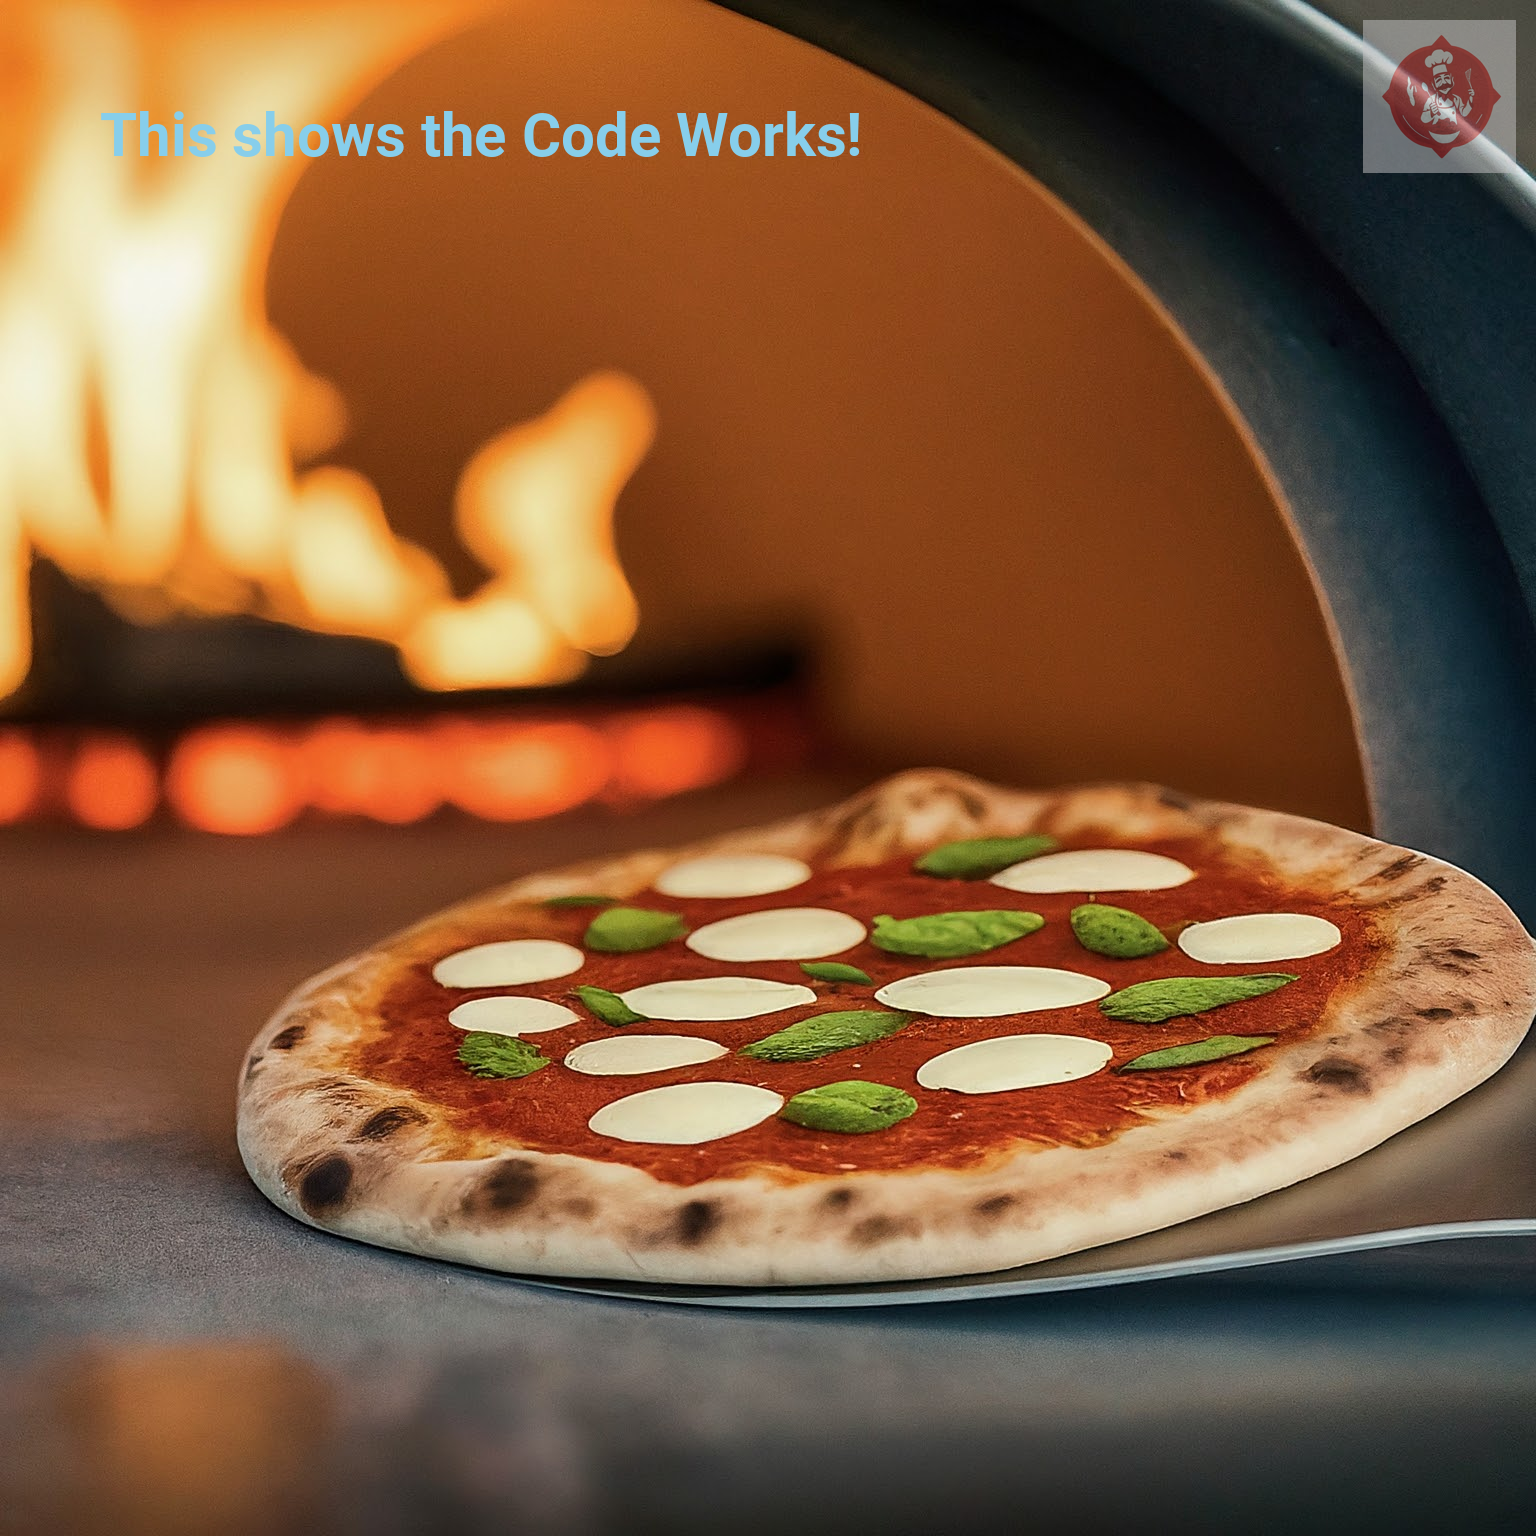

In [10]:
response, generated_code = generate_code(BASE_CODE, **config)
response

### Response Generated

- We can validate the Generated code
- We can validate the generated Output

In [11]:
print(generated_code)

from PIL import Image, ImageColor, ImageFont, ImageDraw


def add_logo(image, logo_path, corner, padding):

    # Load the  logo image.
    logo = Image.open(logo_path)

    # Make the  logo 50% transparent by changing the alpha channel.
    logo = logo.convert("RGBA")
    logo.putalpha(128)

    # Resize the  logo image to be 10% of the image height.
    logo = logo.resize((int(image.height * 0.1), int(image.height * 0.1)))

    # Add the  logo image to the specified corner of the original image.
    if corner == "top left":
        image.paste(logo, (padding, padding), logo)
    elif corner == "top right":
        image.paste(logo, (image.width - logo.width - padding, padding), logo)
    elif corner == "bottom left":
        image.paste(logo, (padding, image.height - logo.height - padding), logo)
    elif corner == "bottom right":
        image.paste(
            logo,
            (image.width - logo.width - padding, image.height - logo.height - padding),
            logo,
        )


### Save the Output & Code

In [12]:
# Save the Output Image
response.save("output.png", "PNG")

In [13]:
# Save the Output Code
with open("generated_code.py", "w") as file:
    file.write(generated_code)

# Conclusion

* The Original Python Function Does not make Logo Transparent
* The New Code works directly end-to-end
* It does the necessary tasks that we have asked it to do ie. Make Logo Transparent
* It respects the function signatures and does not break the working code
* It makes minimal changes to existing code.
* ***The Original Image has not been Modified at all.***
* As we can see below, the Logo has been place in the top right corner
* The Logo has been resized
* The Logo is transparent
* The Text is printed on the image
* The Text has appropriate Size, Colour, Font etc.